Recurrent neural networks : Handle sequences of data

Input to recurrent neural network : a batch of sequences \
[batch_size, sequence_length, num_features
]

In the last two notebooks, we built building blocks which could be reused to build complex models without coding the low level computations like how it was done in fundamentals notebook. Now there is a limitation to this approach. in recurrent networks and some other branched networks, we do not have straight-forward 1 input array and 1 output array during forward and backward pass of an Operation defined in Operation class. This worked well for Dense and Convolution Layers. \
But if we have a branched network, the gradient flow is not simple enough to be flowing in reverse direction during training. we may have to track how the gradients are getting branched and add them at appropriate junctures

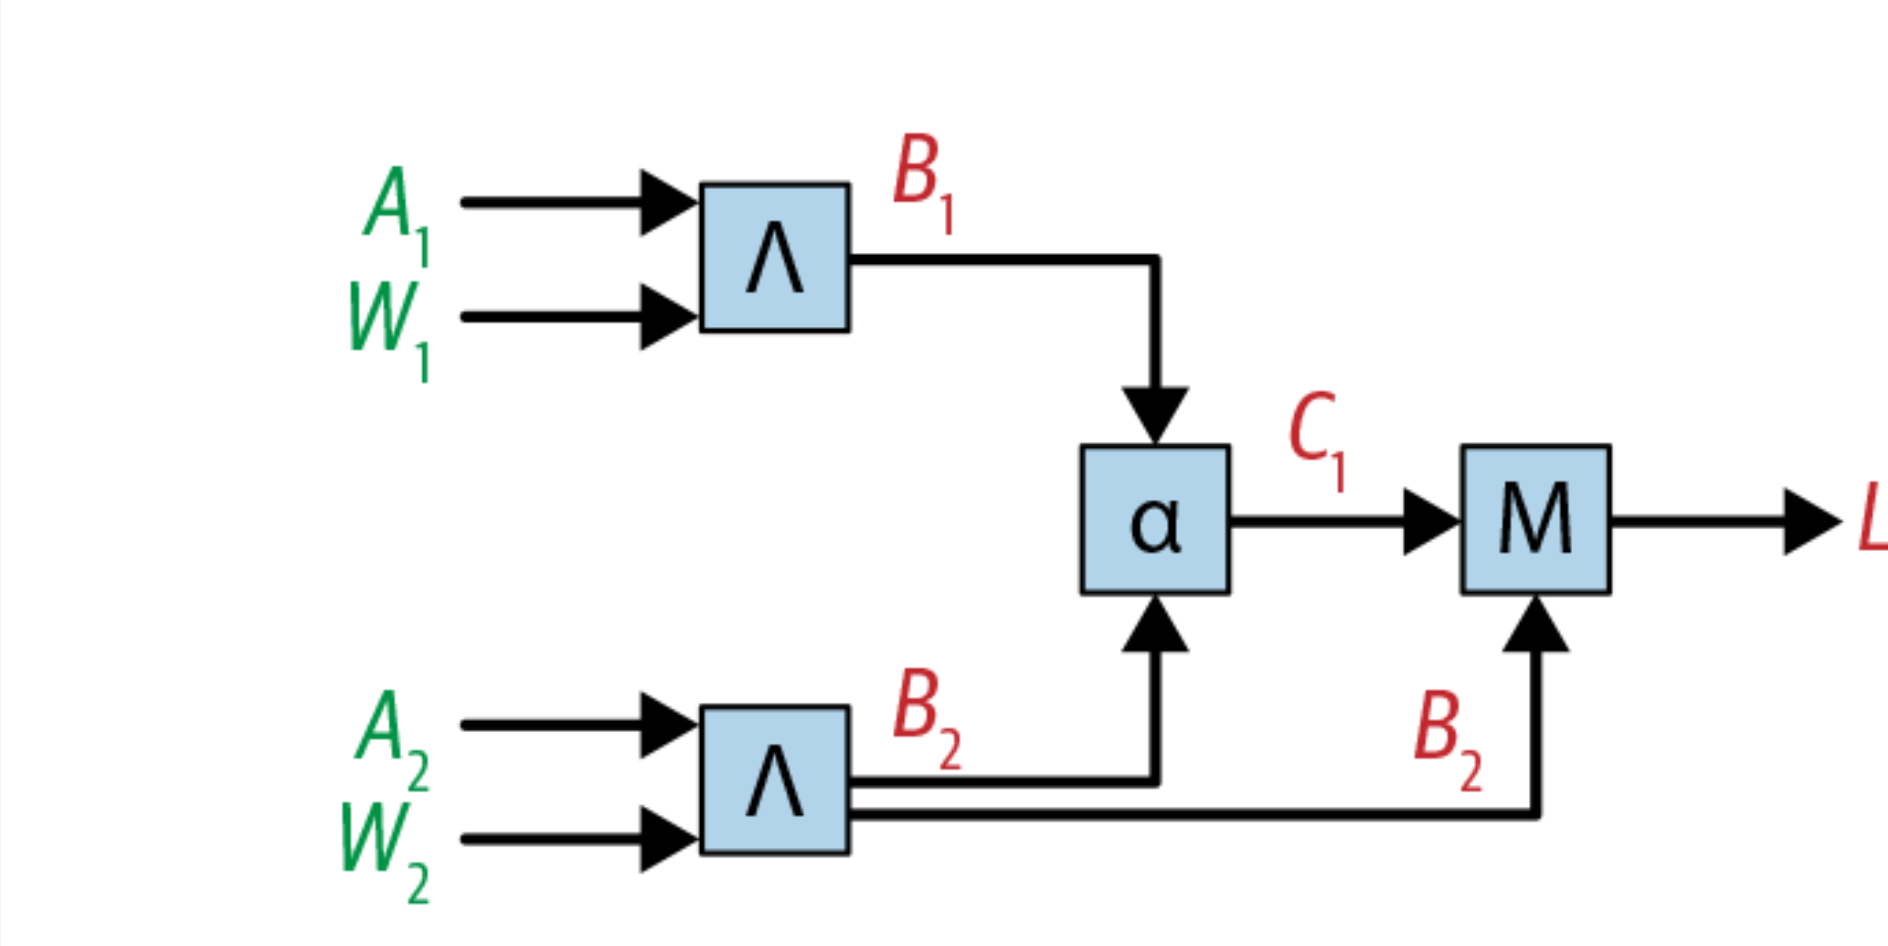

the forward pass can be computed with a bunch of additions and multiplications. but during the forward pass, the Operation class will break. b2 is being passed to alpha and also to M. So, we will have b2 gradient flowing back from both M and alpha.

let us construct a simple illustration \
Forward pass : \
a1 = torch.randn(3,3) \
w1 = torch.randn(3,3) \
a2 = torch.randn(3,3) \
w2 = torch.randn(3,3) 

w3 = torch.randn(3,3) \
wm1 = WeightMultiply(w1) \
wm2 = WeightMultiply(w2) \
add2 = Add(2,1) \
mult3 = Multiply(2,1) 

b1 = wm1.forward(a1) \
b2 = wm2.forward(a2) \
c1 = add2.forward(b1,b2) \
L = mult3.forward(c1,b2) 




c1_grad, b2_grad_1 = mult3.backward(L) \
b1_grad, b2_grad_2 = add2.backward(c1_grad) \
b2_grad = b2_grad_1 + b2_grad_2 \
a1_grad = wm1.backward(b1_grad) \
a2_grad = wm2.backward(b2_grad)


It seems that the Operation Class can be skipped entirely and our model can be written at a low level again like notebook 2. The recurrent network is going to be discussed that way. But frameworks like Pytorch , Tensorflow use automatic differention and reverse auto-diff to handle backpropagation in neural networks for any type of networks. 

Automatic differentiation : A conceptual overview \
In our Neural network framework, the atomic unit is Operation. the class implements forward and backward thereby keeping track of gradients.but it fails for non-linear graphs where there is branching. So, automatic diff takes a different route. it wraps the gradient calcuation and accumulation around individual data elements itself which is then involved in different operations. we will see an example

In [198]:
import numpy as np
from typing import Tuple , List,Callable,Union

In [199]:
a = np.array([1,2,3])
print("Addition using add : ", a.__add__(4))


Addition using add :  [5 6 7]


In [200]:
Numberable = Union[float,int] # type hinting for numbers : int or float

In [201]:
class NumberwithGrad(object):
    def __init__(self, num : Numberable, depends_on : List[Numberable] = None, creation_op : str = " "):
        self.num = num
        self.depends_on = depends_on or [] # if depends_on is None, then we create an empty list
        self.creation_op = creation_op 
        self.grad = None

    def __add__(self, other : Numberable)  : # addition operation overload
        return NumberwithGrad(self.num + ensure_number(other).num, depends_on = [self, ensure_number(other)], creation_op = "add")
    
    def __mul__(self, other : Numberable)  : #mult operation

        out =  NumberwithGrad(self.num * ensure_number(other).num, depends_on = [self, ensure_number(other)], creation_op = "mul")
        return out
    
    def backward(self, grad : Numberable = None ) -> None : 
        if grad is None : 
            self.grad = 1 # first time calling grad

        else:
            if self.grad is None : # no grad accumulated yet
                self.grad = grad
            else:
                self.grad += grad
        
        # if the current numberable is involved in addition with another numberable

        if self.creation_op == "add":
            self.depends_on[0].backward(self.grad)
            self.depends_on[1].backward(self.grad)
        
        # if the current numberable is involved in multiplication

        if self.creation_op == "mul":
            print(type(self.grad), type(self.depends_on[1]))
            new = self.depends_on[1] * self.grad
            self.depends_on[0].backward(new.num)
            
            new = self.depends_on[0] * self.grad
            self.depends_on[1].backward(new.num)
        
    
    


In [202]:
# we use python methods to overload operators that perform addition , subtraction etc
Numberable = Union[float,int] # type hinting for numbers : int or float
def ensure_number(num : Numberable) -> NumberwithGrad:
    if isinstance(num,NumberwithGrad):
        return num
    else:
        return NumberwithGrad(num)

In [203]:
a = NumberwithGrad(3)
b = a * 4
c = b + 5


In [204]:
# if we increase a by epsilon, c should increase by 4*epsilon [deduced from gradient ]
c.backward()

<class 'int'> <class '__main__.NumberwithGrad'>


In [205]:
c.grad, b.grad, a.grad

(1, 1, 4)

with our simple NumberwithGrad class, we are able to get gradients for all the numbers involved in this simple model. the advantage of this framework is that it allows NumberwithGrads object to accumulate gradients even when used in branched neural networks. Also, the gradients for all dependencies are calculated correctly. this can be reused in construction of bigger models. To let the gradients flow correctly in the graph of neurons, we use a DAG to represent the neural network and use topological sort to sort it correctly and go traverse and update the gradients.



Here, we are writing a wrapper around a scalar to perform gradient computations. frameworks like pytorch which have automatic differentiator do in on the tensor level and are much more efficient. support wide variety of operations like sigmoid, tanh and all other activations that can happen on data.

In [206]:
# another branched example
a = NumberwithGrad(3)
b = a + 6
c = b * 4
d = c * (a+2)

print(a.num,b.num,c.num,d.num)

3 9 36 180


In [207]:
d.backward()

<class 'int'> <class '__main__.NumberwithGrad'>
<class 'int'> <class '__main__.NumberwithGrad'>


In [208]:
print(d.grad, c.grad,b.grad,a.grad)

1 5 20 56


Key innovation of recurrent neural networks is that in dense and convolutional neural networks, once the representations for a given input are computed, they are discarded at the next iteration. But in recurrent neural networks, they are preserved through some latent variable and used in subsequent iterations. 

How recurrent layer can be designed :
1. Input will be of shape (batch_size, sequence_length, num_features)
2. Take the first sequence say input[:,0,:] -> pass it through hidden layers and extract output of shape (batch_size, num_outputs). Also, you will update another hidden array of shape (batch_size, hidden_size) which carries information from sequences before. 
3. Concatenate all the outputs finally after parsing all sequences this way. So, final output will be of shape - (batch_size, sequence_length, num_outputs)


RNNNode helper class : 
2 inputs - (batch_size, num_features) , (batch_size, hidden_size) [representation]
2 outputs - (batch_size, num_outputs), (batch_size, hidden_size) [updated representation]

there are two set of weight matrices -> one set of weight matrices which move from layer to layer for each time step and another set of weight matrices which are used between time steps. So, while gradients flow backward , both of these need to be computed. Thus, we also need to accumulate gradients across time steps to update weight matrices.

Each RNN Layer : hidden_size, output_size, an array of shape (1,hidden_size) -> the hidden representations for each layer 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict,  List, Tuple
from copy import deepcopy
from collections import deque
from scipy.special import logsumexp

Activations

In [8]:
def sigmoid(x: np.ndarray):
    return 1 / (1 + np.exp(-x))


def dsigmoid(x: np.ndarray):
    return sigmoid(x) * (1 - sigmoid(x))


def tanh(x: np.ndarray):
    return np.tanh(x)


def dtanh(x: np.ndarray):
    return 1 - np.tanh(x) * np.tanh(x)


def softmax(x, axis=None):
    return np.exp(x - logsumexp(x, axis=axis, keepdims=True))


def batch_softmax(input_array: np.ndarray):
    out = []
    for row in input_array:
        out.append(softmax(row, axis=1))
    return np.stack(out)

Optimizer

In [9]:
class RNNOptimizer(object):
    def __init__(self, lr : float = 0.01, gradient_clipping : bool = True) :
        self.lr = lr
        self.gradient_clipping = gradient_clipping
        self.first = True
    
    def step(self) -> None:
        for layer in self.model.layers:
            for key in layer.params.keys():
                if self.gradient_clipping:
                    np.clip(layer.params[key]['deriv'], -2,2 ,layer.params[key]['deriv'])
                self._update_rule(param = layer.params[key]['value'], grad = layer.params[key]['deriv'])
    
    def _update_rule(self, **kwargs) -> None:
        raise NotImplementedError()

In [10]:
# Stochastic Gradient Descent
class SGD(RNNOptimizer):
    def __init__(self, lr : float = 0.01, gradient_clipping : bool = True) -> None:
        super().__init__(lr, gradient_clipping)

    def _update_rule(self, **kwargs) -> None:
        update = self.lr * kwargs['grad']
        kwargs['param'] -= update

# AdaGrad  
class AdaGrad(RNNOptimizer) : 
    def __init__(self, lr : float = 0.01, gradient_clipping : bool = True) -> None:
        super().__init__(lr, gradient_clipping)
        self.eps = 1e-7
    
    def step(self) -> None:
        if self.first:
            self.sum_squares = {}
            for i, layer in enumerate(self.model.layers):
                self.sum_squares[i] = {}
                for key in layer.params.keys():
                    self.sum_squares[i][key] = np.zeros_like(layer.params[key]['value'])
            self.first = False
        
        for i, layer in enumerate(self.model.layers):
            for key in layer.params.keys():
                if self.gradient_clipping:
                    np.clip(layer.params[key]['deriv'], -2, 2, layer.params[key]['deriv'])
                self._update_rule(param = layer.params[key]['value'], grad = layer.params[key]['deriv'], sum_squares = self.sum_squares[i][key])
        
    def _update_rule(self, **kwargs) -> None:
        kwargs['sum_squares'] = self.eps + np.power(kwargs['grad'],2)
        lr = np.divide(self.lr, np.sqrt(kwargs['sum_squares']))
        kwargs['param'] -= lr * kwargs['grad']







In [11]:
# Loss class

class Loss(object):
    def __init__(self) -> None:
        pass
    
    def forward(self, prediction, target) -> float:
        self.prediction = prediction
        self.target = target
        assert(self.prediction.shape == self.target.shape)
        loss = self._output()
        return loss
    
    def backward(self) -> np.ndarray:
        self.input_grad = self._input_grad()
        assert(self.input_grad.shape == self.prediction.shape)
        return self.input_grad
    
    def _output(self) -> float:
        raise NotImplementedError()
    
    def _input_grad(self) -> np.ndarray:    
        raise NotImplementedError()

In [12]:
#softmax cross entropy loss
class SoftmaxCrossEntropyLoss(Loss):
    def __init__(self, eps : float = 1e-9) -> None:
        super().__init__()
        self.eps = eps
        self.single_class = False
    
    def _output(self) -> float:
        out = []
        for row in self.prediction:
            out.append(softmax(row, axis=1))
        softmax_preds = np.stack(out)
        # to avoid numerical instability
        self.softmax_preds = np.clip(softmax_preds, self.eps, 1-self.eps)

        softmax_cross_entopy_loss = -1.0 * self.target * np.log(self.softmax_preds) - (1.0 - self.target) * np.log(1-self.softmax_preds)
        return np.sum(softmax_cross_entopy_loss)
   
    def _input_grad(self) -> np.ndarray:
        return (self.softmax_preds - self.target)
    
    



Let us build the RNN Node, RNN Layer and the RNN trainer which will help us construct and train RNN networks

In [13]:
class RNNNode(object):
    def __init__(self):
        pass

    def forward(self, x_in : np.ndarray, H_in : np.ndarray,params_dict : Dict[str, Dict[str,np.ndarray]]) -> Tuple[np.ndarray] :
        self.x_in = x_in
        self.H_in = H_in
        self.Z = np.column_stack((x_in, H_in))
        self.H_int = np.dot(self.Z, params_dict['W_h']['value']) + params_dict['b_h']['value'] # hidden state = W_f * (x_in+H_in) + b_f
        self.H_out = np.tanh(self.H_int) # activation function
        self.X_out = np.dot(self.H_out, params_dict['W_o']['value']) + params_dict['b_o']['value']
        return self.X_out, self.H_out
    
    def backward(self, X_out_grad : np.ndarray, H_out_grad : np.ndarray, params_dict : Dict[str, Dict[str, np.ndarray]]) -> Tuple[np.ndarray]:
        assert(X_out_grad.shape == self.X_out.shape)
        assert(H_out_grad.shape == self.H_out.shape)
        params_dict['b_o']['deriv'] += np.sum(X_out_grad,axis=0) # same matrices are used for all nodes, hence the addition to accumulate gradients
        params_dict['W_o']['deriv'] += np.dot(self.H_out.T, X_out_grad)

        dh = np.dot(X_out_grad, params_dict['W_o']['value'].T)
        dh += H_out_grad

        dh_int = dh * dtanh(self.H_int)

        params_dict['W_h']['deriv'] += np.dot(self.Z.T, dh_int)
        params_dict['b_h']['deriv'] += np.sum(dh_int, axis=0)

        dz = np.dot(dh_int, params_dict['W_h']['value'].T)

        x_in_grad = dz[:,:self.x_in.shape[1]]
        H_in_grad = dz[:, self.x_in.shape[1]:]

        assert(self.x_in.shape == x_in_grad.shape)
        assert(self.H_in.shape == H_in_grad.shape)

        return x_in_grad, H_in_grad







In [14]:
class RNNLayer(object):
    def __init__(self, hidden_size : int, output_size:  int, weight_scale : float) -> None:
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.weight_scale = weight_scale
        self.start_H = np.zeros((1, self.hidden_size))
        self.first = True
    
    def _init_params(self, input_arr : np.ndarray) -> None:
        self.vocab_size = input_arr.shape[2]
    
        if not self.weight_scale:
           self.weight_scale = 2.0 / (self.vocab_size + self.output_size)
        
        self.params = {}
        self.params['W_h'] = {}
        self.params['b_h'] = {}
        self.params['W_o'] = {}
        self.params['b_o'] = {}
        self.params['W_h']['value'] = np.random.normal(loc=0.0,scale = self.weight_scale, size=(self.hidden_size + self.vocab_size, self.hidden_size) )
        self.params['b_h']['value'] = np.random.normal(loc=0.0, scale=self.weight_scale, size=(1, self.hidden_size))
        self.params['W_o']['value'] = np.random.normal(loc=0.0, scale=self.weight_scale,size=(self.hidden_size, self.output_size))
        self.params['b_o']['value'] = np.random.normal(loc=0.0, scale=self.weight_scale, size=(1, self.output_size))

        self.params['W_h']['deriv']  = np.zeros_like(self.params['W_h']['value'])
        self.params['b_h']['deriv']  = np.zeros_like(self.params['b_h']['value'])
        self.params['W_o']['deriv']  = np.zeros_like(self.params['W_o']['value'])
        self.params['b_o']['deriv']  = np.zeros_like(self.params['b_o']['value'])

        self.cells = [RNNNode() for _ in range(input_arr.shape[1])]
    
    def _clear_gradients(self) -> None :
        for key in self.params.keys():
            self.params[key]['deriv'] = np.zeros_like(self.params[key]['value'])
        
    def forward(self, input_arr : np.ndarray) : 
        if self.first:
            self._init_params(input_arr)
            self.first = False
        
        batch_size = input_arr.shape[0]
        seq_length = input_arr.shape[1]
        H_in = np.copy(self.start_H)
        H_in = np.repeat(H_in, batch_size, axis=0)
        x_seq_out = np.zeros((batch_size, seq_length, self.output_size))
        for t in range(seq_length):
            x_in = input_arr[:, t, :]
            y_out, H_in = self.cells[t].forward(x_in, H_in, self.params)
            x_seq_out[:,t,:] = y_out
        self.start_H = H_in.mean(axis=0, keepdims=True)
        return x_seq_out
    
    def backward(self, output_grad : np.ndarray):
        batch_size = output_grad.shape[0]
        h_in_grad = np.zeros((batch_size, self.hidden_size))
        seq_length = output_grad.shape[1]
        x_in_grad = np.zeros((batch_size, seq_length, self.vocab_size))
        for t in range(seq_length):
            x_out_grad = output_grad[:,t,:]
            grad_out, h_in_grad = self.cells[t].backward(x_out_grad, h_in_grad, self.params)
            x_in_grad[:,t,:] = grad_out
        return x_in_grad




        
        







In [15]:
# vanilla RNN network
class RNNModel(object):
    def __init__(self, sequence_length : int, vocab_size : int, layers : List[RNNLayer], loss : Loss) :
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.layers = layers
        self.loss = loss
        for layer in self.layers:
            setattr(layer, "sequence_length", sequence_length)
    
    def forward(self,x_batch : np.ndarray) :
        for layer in self.layers:
            x_batch = layer.forward(x_batch)
        return x_batch
    
    def backward(self,out_grad : np.ndarray) :
        for layer in reversed(self.layers):
            out_grad = layer.backward(out_grad)
        return out_grad
    
    def single_step(self, x_batch : np.ndarray, y_batch : np.ndarray) -> float:
        out = self.forward(x_batch)
        loss = self.loss.forward(out, y_batch)
        loss_grad = self.loss.backward()
        # zero out the gradients of each layer
        for layer in self.layers:
            layer._clear_gradients()
        
        self.backward(loss_grad)

        return loss



RNN trainer : the objective is to read a text file and generate text of the same pattern as the text file.

In [16]:
class RNNTrainer(object):
    def __init__(self, data : str, model : RNNModel, batch_size : int, optim : RNNOptimizer) :
        self.data = open(data,'r').read()
        self.model = model
        self.chars = list(set(self.data))
        self.batch_size = batch_size
        self.optim = optim
        self.vocab_size = len(self.chars)
        print(self.vocab_size)
        self.sequence_length = self.model.sequence_length
        self.char_to_idx = {char : idx for idx, char in enumerate(self.chars)}
        self.idx_to_char = {idx : char for idx, char in enumerate(self.chars)}
        setattr(self.optim, "model", self.model)
    
    def _generate_input(self , start_pos : int) :
        input_indices = np.zeros((self.batch_size, self.sequence_length), dtype=int)
        target_indices = np.zeros((self.batch_size, self.sequence_length),dtype=int)

        for i in range(self.batch_size):
            input_indices[i,:] = np.array([self.char_to_idx[char] for char in self.data[start_pos + i : start_pos + self.sequence_length + i]])
            target_indices[i,:] = np.array([self.char_to_idx[char] for char in self.data[start_pos + i +1 : start_pos + i + self.sequence_length + 1]])
        
        return input_indices, target_indices
    
    def _generate_one_hot_array(self, indices : np.ndarray) -> np.ndarray : 
        one_hot_array = np.zeros((self.batch_size, self.sequence_length, self.vocab_size))
        for i in range(self.batch_size):
            for j in range(self.sequence_length):
                one_hot_array[i,j,indices[i,j]] = 1.0
        return one_hot_array
    
    def sample_outputs(self, input_char : int, sample_length : int) -> str:
        model_copy = deepcopy(self.model)
        indices = []
        for i in range(sample_length):
            input = np.zeros((1,1,self.vocab_size))
            input[0,0,input_char] = 1.0
            y_batch = self.model.forward(input)
            y_softmax = batch_softmax(y_batch)
            y_sample = np.random.choice(range(self.vocab_size), p = y_softmax.ravel())
            indices.append(y_sample)
        txt = ''.join(self.idx_to_char[idx] for idx in indices)
        return txt
    
    def train(self, num_iterations : int, sample_every : int = 100) -> None:
        plot_iter = np.zeros((0))
        plot_loss = np.zeros((0))
        num_iter = 0
        start_pos = 0

        moving_average = deque(maxlen=100)

        while num_iter < num_iterations:
            if (start_pos + self.sequence_length + self.batch_size + 1) > len(self.data):
                start_pos = 0
            
            input_indices, target_indices = self._generate_input(start_pos)
            input_one_hot, target_one_hot = self._generate_one_hot_array(input_indices), self._generate_one_hot_array(target_indices)

            loss = self.model.single_step(input_one_hot, target_one_hot)
            self.optim.step()
            moving_average.append(loss)
            mean_loss = np.mean(moving_average)

            start_pos += self.batch_size
            plot_iter = np.append(plot_iter, [num_iter])
            plot_loss = np.append(plot_loss, [mean_loss])
            if num_iter % sample_every == 0:
                print(f"Iteration {num_iter} loss: {mean_loss}")

            
            num_iter += 1

        sample_text = self.sample_outputs(self.char_to_idx[self.data[start_pos]], 200)
        print(sample_text)
        plt.plot(plot_iter,plot_loss)
        plt.show()
            








                                           


Iteration 0 loss: 1636.306601143503
Iteration 100 loss: 1429.9707290162326
Iteration 200 loss: 1326.1156585049255
Iteration 300 loss: 1279.1130980853306
Iteration 400 loss: 1252.6551916826602
Iteration 500 loss: 1265.1573207442698
Iteration 600 loss: 1250.62634813382
Iteration 700 loss: 1231.7100070985705
Iteration 800 loss: 1222.9120327819783
Iteration 900 loss: 1225.979243717872
Iteration 1000 loss: 1234.6038736918388
Iteration 1100 loss: 1232.6547454458375
Iteration 1200 loss: 1247.4814326889082
Iteration 1300 loss: 1247.270220988764
Iteration 1400 loss: 1250.1651747608944
Iteration 1500 loss: 1277.6129556250128
Iteration 1600 loss: 1298.6101552736397
Iteration 1700 loss: 1266.7599879325703
Iteration 1800 loss: 1286.3684406311777
Iteration 1900 loss: 1311.2924682695839
  h d u  e   ri  he ktmn toe ,tdamhydlydana lyyamt,sd,t a etc mcuf  ot t
 nosft   e
ee   c  esyt ahe a
 gdyss
 fiafes tneseio  diei  tmeslis oee, rb :ama y, e oo h atsfef
fs,   ta u
 dtsns
srian  ehte


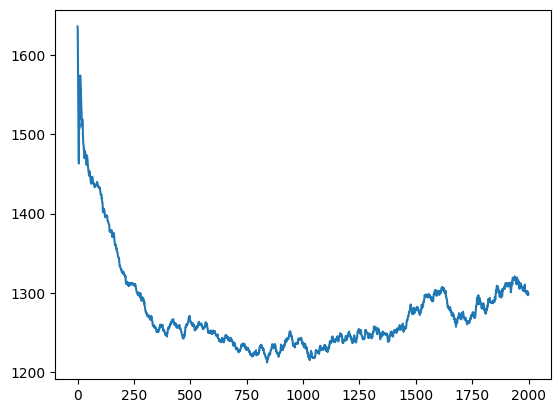

In [219]:
layers  = [RNNLayer(hidden_size=256,output_size=62,weight_scale=None)]
model = RNNModel(layers=layers,vocab_size=62,sequence_length=10,loss = SoftmaxCrossEntropyLoss())
optim = AdaGrad(lr = 0.005, gradient_clipping=True)
trainer = RNNTrainer(data='input.txt',model=model,batch_size=32,optim=optim)
trainer.train(num_iterations=2000)

we see that the text is not at all coherent, also, there is a dip in loss till a certain number of iterations and then it increases.

RNNS face a problem. we use a matrix for getting hidden representation and then another matrix for getting the output. the same matrices are used for all time steps and hence there is a lot of gradient flow into these matrices. this can lead to the gradient vanishing or gradient explosion problem. the gradients as they get chained across operations, they become zero or they blow to a large value. \
Other variants like GRU / LSTM are used to get rid of this limitation

GRU NODES : 
In the more advanced RNN variants like the GRU (Gated Recurrent Unit) , the insight is to have more computations which determine how much of the information in the hidden state is useful i.e how much to retain and how much to forget. in the Vanilla RNNs we have the same set of matrix manipulations again and again and there may not be enough information about how much of past to remember and how much to forget. A simple example is in language modeling, if we encounter . or :, we usually forget much of the content before and begin something new [at least in terms of structure of the content]. the Vanilla RNNs may not be able to model these. they are blind towards these subtle aspects of languages.

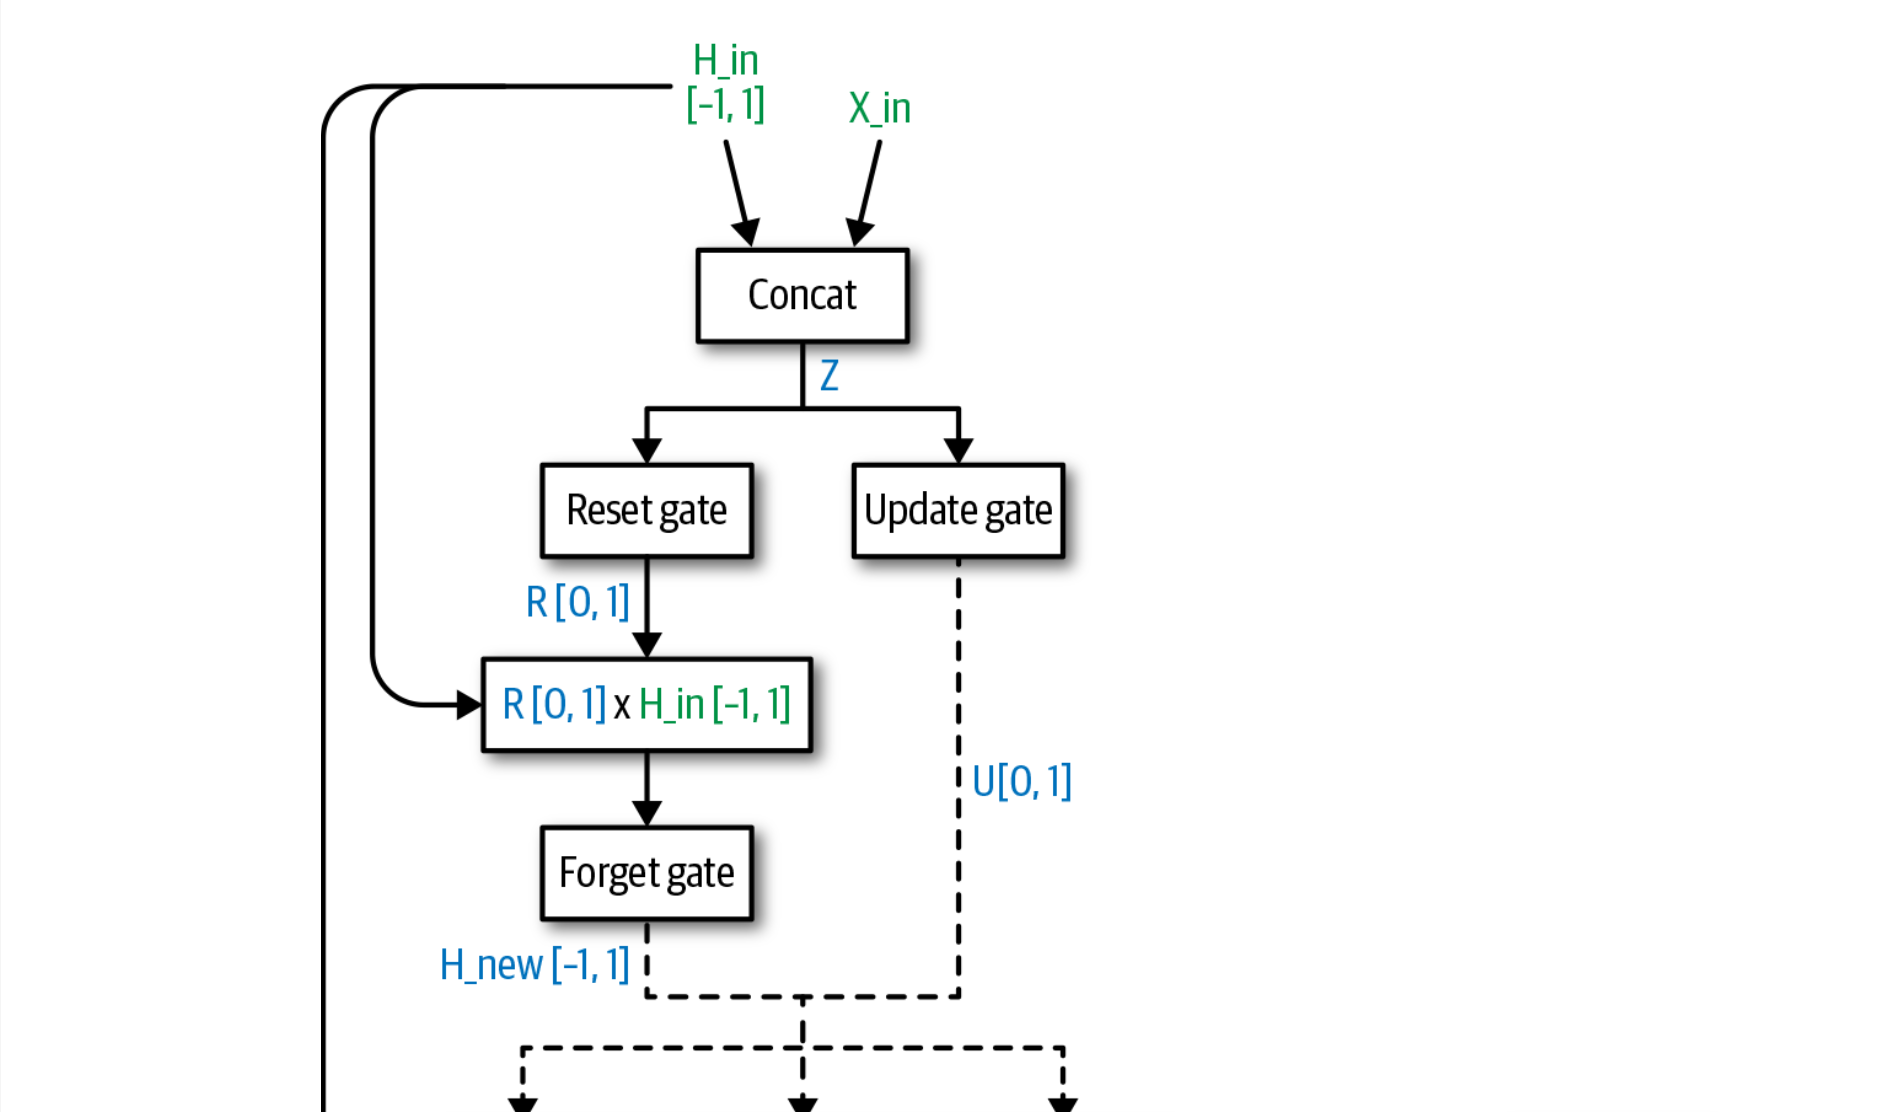

In [223]:
class GRUNode(object):
    def __init__(self) -> None:
        pass

    def forward(self, X_in : np.ndarray, H_in : np.ndarray, params_dict : Dict[str, Dict[str, np.ndarray]]):
        self.X_in = X_in
        self.H_in = H_in
        # reset gate
        self.X_r = np.dot(X_in, params_dict['W_xr']['value'])
        self.H_r = np.dot(H_in, params_dict['W_hr']['value'])

        # update gate
        self.X_u = np.dot(X_in, params_dict['W_xu']['value'])
        self.H_u = np.dot(H_in, params_dict['W_hu']['value'])

        #gates
        self.r_int = self.X_r + self.H_r + params_dict['b_r']['value']
        self.r = sigmoid(self.r_int)

        self.u_int = self.X_u + self.H_u + params_dict['b_u']['value']
        self.u = sigmoid(self.u_int)

        # candidate
        self.h_reset = self.r * H_in
        self.X_h = np.dot(X_in, params_dict['W_xh']['value'])
        self.H_h = np.dot(self.h_reset, params_dict['W_hh']['value'])
        self.h_int = self.X_h + self.H_h + params_dict['b_h']['value']

        self.h_candidate = tanh(self.h_int)

        self.H_out = self.u * H_in + (1 - self.u) * self.h_candidate
        self.X_out = np.dot(self.H_out, params_dict['W_ho']['value']) + params_dict['b_o']['value']

        return self.X_out, self.H_out
    
    def backward(self, X_out_grad : np.ndarray, H_out_grad : np.ndarray, params_dict : Dict[str, Dict[str, np.ndarray]]):
        assert(X_out_grad.shape == self.X_out.shape)
        assert(H_out_grad.shape == self.H_out.shape)

        params_dict['b_o']['deriv'] += np.sum(X_out_grad, axis=0)
        params_dict['W_ho']['deriv'] += np.dot(self.H_out.T, X_out_grad)

        dh_out = np.dot(X_out_grad, params_dict['W_ho']['value'].T)
        dh_out += H_out_grad 

        du = dh_out * self.H_in - dh_out * self.h_candidate
        dh_candidate = dh_out * self.u

        dh_int = dh_candidate * dtanh(self.h_int)

        params_dict['b_h']['deriv'] += dh_int.sum(axis=0)
        params_dict['W_hh']['deriv'] += np.dot(self.h_reset.T, dh_int)
        params_dict['W_xh']['deriv'] += np.dot(self.X_in.T, dh_int)

        dX_in = np.dot(dh_int, params_dict['W_xh']['value'].T)
        dh_reset = np.dot(dh_int, params_dict['W_hh']['value'].T)

        dr = dh_reset * self.H_in
        dH_in = dh_reset * self.r

        du_int = du * dsigmoid(self.u_int)
        params_dict['b_u']['deriv'] += du_int.sum(axis=0)
        dr_int = dsigmoid(self.r_int) * dr 

        params_dict['b_r']['deriv'] += dr_int.sum(axis=0)

        params_dict['W_xu']['deriv'] += np.dot(self.X_in.T, du_int)
        dX_in += np.dot(du_int, params_dict['W_xu']['value'].T)

        params_dict['W_hu']['deriv'] += np.dot(self.H_in.T, du_int)
        dH_in += np.dot(du_int, params_dict['W_hu']['value'].T)

        params_dict['W_xr']['deriv'] += np.dot(self.X_in.T, dr_int)
        dX_in += np.dot(dr_int, params_dict['W_xr']['value'].T)

        params_dict['W_hr']['deriv'] += np.dot(self.H_in.T, dr_int)
        dH_in += np.dot(dr_int, params_dict['W_hr']['value'].T)

        return dX_in, dH_in




        










In [224]:
class GRULayer(object):
    def __init__(self, hidden_size : int, output_size : int, weight_scale : float = None) -> None:
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.weight_scale = weight_scale
        self.first  =True
        self.start_H = np.zeros((1,self.hidden_size))
    
    def _init_params(self, input_arr : np.ndarray):
        self.vocab_size = input_arr.shape[2]
        self.params = {}
        self.params['W_xr'] = {}
        self.params['W_hr'] = {}
        self.params['b_r'] = {}
        self.params['W_xu'] = {}
        self.params['W_hu'] = {}
        self.params['b_u'] = {}
        self.params['W_xh'] = {}
        self.params['W_hh'] = {}
        self.params['b_h'] = {}
        self.params['W_ho'] = {}
        self.params['b_o'] = {}

        if not self.weight_scale:
            self.weight_scale = 2. / (self.vocab_size + self.output_size)
        
        self.params['W_xr']['value'] = np.random.normal(loc=0.,scale=self.weight_scale, size=(self.vocab_size, self.hidden_size))
        self.params['W_hr']['value'] = np.random.normal(loc=0., scale=self.weight_scale, size=(self.hidden_size, self.hidden_size))
        self.params['b_r']['value'] = np.random.normal(loc=0., scale=self.weight_scale, size=(1, self.hidden_size))
        self.params['W_xu']['value'] = np.random.normal(loc=0.,scale=self.weight_scale, size=(self.vocab_size, self.hidden_size))
        self.params['W_hu']['value'] = np.random.normal(loc=0., scale=self.weight_scale, size=(self.hidden_size, self.hidden_size))
        self.params['b_u']['value'] = np.random.normal(loc=0., scale=self.weight_scale, size=(1, self.hidden_size))
        self.params['W_xh']['value'] = np.random.normal(loc=0., scale=self.weight_scale, size=(self.vocab_size,self.hidden_size))
        self.params['W_hh']['value'] = np.random.normal(loc = 0., scale=self.weight_scale, size=(self.hidden_size, self.hidden_size))
        self.params['b_h']['value'] = np.random.normal(loc=0., scale=self.weight_scale, size=(1, self.hidden_size))
        self.params['W_ho']['value'] = np.random.normal(loc=0., scale=self.weight_scale, size=(self.hidden_size, self.output_size))
        self.params['b_o']['value'] = np.random.normal(loc=0., scale=self.weight_scale, size=(1, self.output_size))\
        
        for key in self.params.keys():
            self.params[key]['deriv'] = np.zeros_like(self.params[key]['value'])
        
        self.cells = [GRUNode() for _ in range(input_arr.shape[1])]

    def _clear_gradients(self):
        for key in self.params.keys():
            self.params[key]['deriv'] = np.zeros_like(self.params[key]['deriv'])
    
    def forward(self, input_arr : np.ndarray):
        if self.first:
            self._init_params(input_arr)
            self.first = False

        batch_size = input_arr.shape[0]
        sequence_length = input_arr.shape[1]
        H_in = np.copy(self.start_H)
        H_in = np.repeat(H_in, batch_size, axis=0)
        x_seq_out =np.zeros((batch_size, sequence_length, self.output_size))
        
        for t in range(sequence_length):
            x_in = input_arr[:,t,:]
            y_out, H_in = self.cells[t].forward(x_in, H_in, self.params)
            x_seq_out[:,t,:] = y_out 
        
        self.start_H = H_in.mean(axis=0, keepdims=True)
        return x_seq_out
    
    def backward(self, out_grad : np.ndarray):
        batch_size = out_grad.shape[0]
        sequence_length = out_grad.shape[1]
        H_in_grad = np.zeros((batch_size, self.hidden_size))
        x_seq_in_grad = np.zeros((batch_size, sequence_length, self.vocab_size))
        for t in reversed(range(sequence_length)):
            x_out_grad = out_grad[:,t,:]
            x_in_grad, H_in_grad = self.cells[t].backward(x_out_grad, H_in_grad,self.params)
            x_seq_in_grad[:,t,:] = x_in_grad 
        
        return x_seq_in_grad







with GRU we have a better loss, but the text is still not great! still not readable English. but it follows the dialogue format of Shakespeare text. Also, the least model is at around 1000 iterations, so we could stop there. also, we could bring in other optimizations like early stopping, dropout, decay in learning rate

let us a bigger model and increase sequence length as well

62
Iteration 0 loss: 1639.120546079503
Iteration 100 loss: 1380.7876305824248
Iteration 200 loss: 1327.2595686286545
Iteration 300 loss: 1288.557983995776
Iteration 400 loss: 1266.7284684697656
Iteration 500 loss: 1265.9833337713756
Iteration 600 loss: 1272.340389017047
Iteration 700 loss: 1250.2292124968847
Iteration 800 loss: 1242.5434503397241
Iteration 900 loss: 1248.1580293114575
e  hh o,h hre,   
e,u o se    .    iee 
d
 ea   rr,roi io in nh r ig t os  e l
 
e
e eetuo  ,  y,  reifiylo  n Wr n
,es oor ohee er  ea   hh. fm,e ro oig 
o r he e  f m  no apse curo iiouo h, u,a 

  


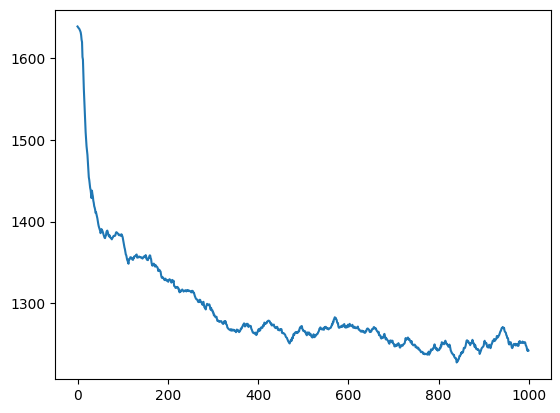

In [234]:
layers  = [GRULayer(hidden_size=256,output_size=128,weight_scale=None),GRULayer(hidden_size=128,output_size=62,weight_scale=None)]
model = RNNModel(layers=layers,vocab_size=62,sequence_length=10,loss = SoftmaxCrossEntropyLoss())
optim = AdaGrad(lr = 0.001, gradient_clipping=True)
trainer = RNNTrainer(data='input.txt',model=model,batch_size=32,optim=optim)
trainer.train(num_iterations=1000)

LSTM : There is another variant of RNN called LSTM which is more  effective in modeling sequences of longer contexts like language modeling -> more popular.

In LSTM,to get how much of hidden representation to take and how much to forget, we have a dedicated vector called Cell state. it can be though of as an escalator which travels parallel to the usual pipeline and the network can use the usual pipeline taking the hidden representation or take the escalator forgetting some aspects of the hidden representation. 

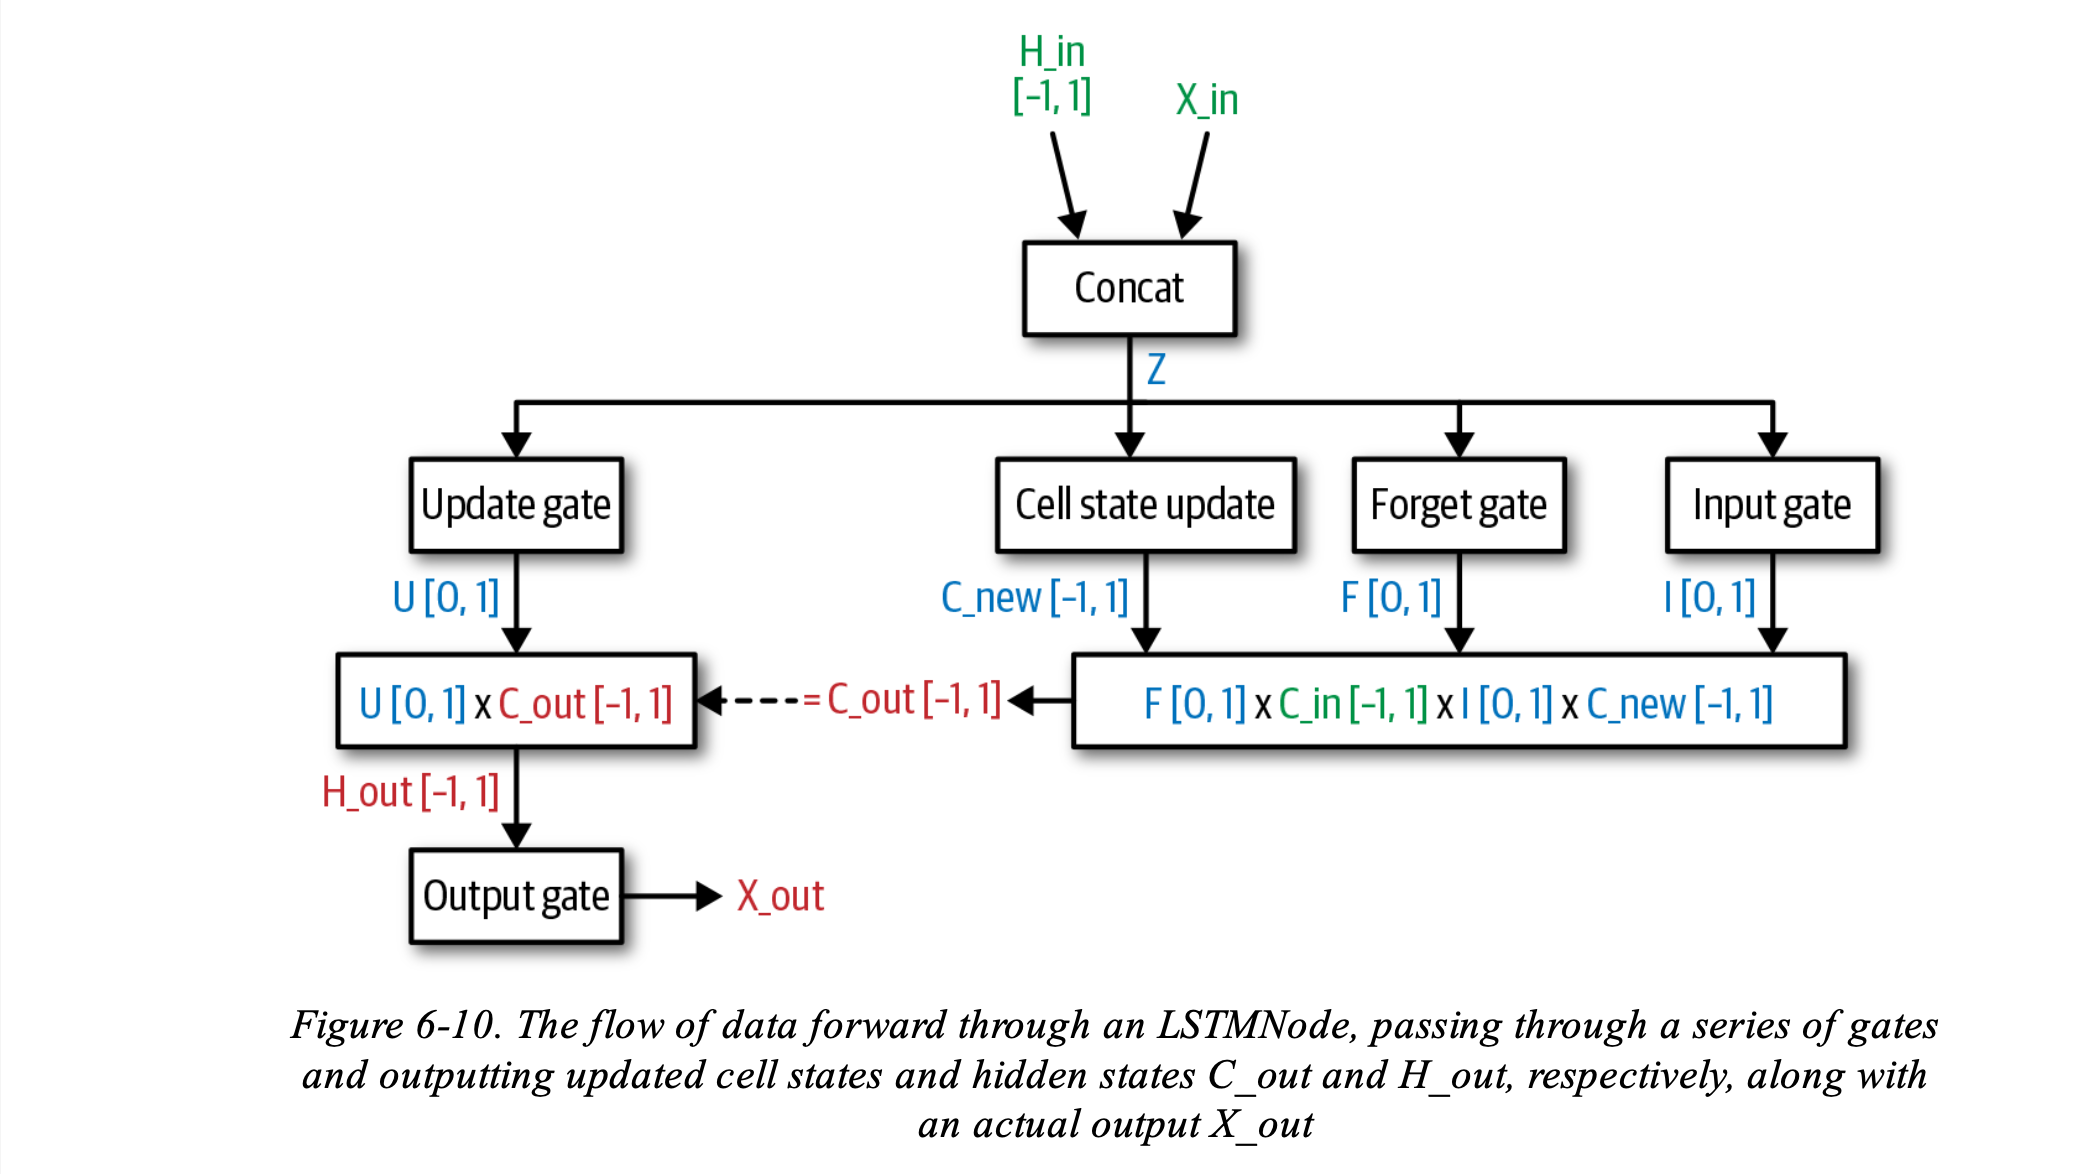

In [23]:
class LSTMNode:

    def __init__(self):
        '''
        param hidden_size: int - the number of "hidden neurons" in the LSTM_Layer of which this node is a part.
        param vocab_size: int - the number of characters in the vocabulary of which we are predicting the next
        character.
        '''
        pass
        
    def forward(self, 
                X_in: np.ndarray, 
                H_in: np.ndarray, 
                C_in: np.ndarray, 
                params_dict: Dict[str, Dict[str, np.ndarray]]):
        '''
        param X_in: numpy array of shape (batch_size, vocab_size)
        param H_in: numpy array of shape (batch_size, hidden_size)
        param C_in: numpy array of shape (batch_size, hidden_size)
        return self.X_out: numpy array of shape (batch_size, output_size)
        return self.H: numpy array of shape (batch_size, hidden_size)
        return self.C: numpy array of shape (batch_size, hidden_size)
        '''
        self.X_in = X_in
        self.C_in = C_in

        self.Z = np.column_stack((X_in, H_in))
        
        self.f_int = np.dot(self.Z, params_dict['W_f']['value']) + params_dict['B_f']['value']
        self.f = sigmoid(self.f_int)
        
        self.i_int = np.dot(self.Z, params_dict['W_i']['value']) + params_dict['B_i']['value']
        self.i = sigmoid(self.i_int)
        self.C_bar_int = np.dot(self.Z, params_dict['W_c']['value']) + params_dict['B_c']['value']
        self.C_bar = tanh(self.C_bar_int)

        self.C_out = self.f * C_in + self.i * self.C_bar
        self.o_int = np.dot(self.Z, params_dict['W_o']['value']) + params_dict['B_o']['value']
        self.o = sigmoid(self.o_int)
        self.H_out = self.o * tanh(self.C_out)

        self.X_out = np.dot(self.H_out, params_dict['W_v']['value']) + params_dict['B_v']['value']
        
        return self.X_out, self.H_out, self.C_out 


    def backward(self, 
                 X_out_grad: np.ndarray, 
                 H_out_grad: np.ndarray, 
                 C_out_grad: np.ndarray, 
                 params_dict: Dict[str, Dict[str, np.ndarray]]):
        '''
        param loss_grad: numpy array of shape (1, vocab_size)
        param dh_next: numpy array of shape (1, hidden_size)
        param dC_next: numpy array of shape (1, hidden_size)
        param LSTM_Params: LSTM_Params object
        return self.dx_prev: numpy array of shape (1, vocab_size)
        return self.dH_prev: numpy array of shape (1, hidden_size)
        return self.dC_prev: numpy array of shape (1, hidden_size)
        '''
        
        assert(X_out_grad.shape ==  self.X_out.shape)
        assert(H_out_grad.shape ==  self.H_out.shape)
        assert(C_out_grad.shape ==  self.C_out.shape)

        params_dict['W_v']['deriv'] += np.dot(self.H_out.T, X_out_grad)
        params_dict['B_v']['deriv'] += X_out_grad.sum(axis=0)

        dh_out = np.dot(X_out_grad, params_dict['W_v']['value'].T)        
        dh_out += H_out_grad
                         
        do = dh_out * tanh(self.C_out)
        do_int = dsigmoid(self.o_int) * do
        params_dict['W_o']['deriv'] += np.dot(self.Z.T, do_int)
        params_dict['B_o']['deriv'] += do_int.sum(axis=0)

        dC_out = dh_out * self.o * dtanh(self.C_out)
        dC_out += C_out_grad
        dC_bar = dC_out * self.i
        dC_bar_int = dtanh(self.C_bar_int) * dC_bar
        params_dict['W_c']['deriv'] += np.dot(self.Z.T, dC_bar_int)
        params_dict['B_c']['deriv'] += dC_bar_int.sum(axis=0)

        di = dC_out * self.C_bar
        di_int = dsigmoid(self.i_int) * di
        params_dict['W_i']['deriv'] += np.dot(self.Z.T, di_int)
        params_dict['B_i']['deriv'] += di_int.sum(axis=0)

        df = dC_out * self.C_in
        df_int = dsigmoid(self.f_int) * df
        params_dict['W_f']['deriv'] += np.dot(self.Z.T, df_int)
        params_dict['B_f']['deriv'] += df_int.sum(axis=0)

        dz = (np.dot(df_int, params_dict['W_f']['value'].T)
             + np.dot(di_int, params_dict['W_i']['value'].T)
             + np.dot(dC_bar_int, params_dict['W_c']['value'].T)
             + np.dot(do_int, params_dict['W_o']['value'].T))
    
        dx_prev = dz[:, :self.X_in.shape[1]]
        dH_prev = dz[:, self.X_in.shape[1]:]
        dC_prev = self.f * dC_out

        return dx_prev, dH_prev, dC_prev

In [24]:
class LSTMLayer:

    def __init__(self,
                 hidden_size: int,
                 output_size: int,
                 weight_scale: float = 0.01):
        '''
        param sequence_length: int - length of sequence being passed through the network
        param vocab_size: int - the number of characters in the vocabulary of which we are predicting the next
        character.
        param hidden_size: int - the number of "hidden neurons" in the LSTM_Layer of which this node is a part.
        param learning_rate: float - the learning rate
        '''
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.weight_scale = weight_scale
        self.start_H = np.zeros((1, hidden_size))
        self.start_C = np.zeros((1, hidden_size))        
        self.first = True

        
    def _init_params(self,
                     input_: np.ndarray):
        
        self.vocab_size = input_.shape[2]

        self.params = {}
        self.params['W_f'] = {}
        self.params['B_f'] = {}
        self.params['W_i'] = {}
        self.params['B_i'] = {}
        self.params['W_c'] = {}
        self.params['B_c'] = {}
        self.params['W_o'] = {}
        self.params['B_o'] = {}        
        self.params['W_v'] = {}
        self.params['B_v'] = {}
        
        self.params['W_f']['value'] = np.random.normal(loc=0.0,
                                                       scale=self.weight_scale,
                                                       size =(self.hidden_size + self.vocab_size, self.hidden_size))
        self.params['B_f']['value'] = np.random.normal(loc=0.0,
                                                       scale=self.weight_scale,
                                                       size=(1, self.hidden_size))
        self.params['W_i']['value'] = np.random.normal(loc=0.0,
                                                       scale=self.weight_scale,
                                                       size=(self.hidden_size + self.vocab_size, self.hidden_size))
        self.params['B_i']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(1, self.hidden_size))
        self.params['W_c']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(self.hidden_size + self.vocab_size, self.hidden_size))
        self.params['B_c']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(1, self.hidden_size))
        self.params['W_o']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(self.hidden_size + self.vocab_size, self.hidden_size))
        self.params['B_o']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(1, self.hidden_size))       
        self.params['W_v']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(self.hidden_size, self.output_size))
        self.params['B_v']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(1, self.output_size))
        
        for key in self.params.keys():
            self.params[key]['deriv'] = np.zeros_like(self.params[key]['value'])
        
        self.cells = [LSTMNode() for x in range(input_.shape[1])]


    def _clear_gradients(self):
        for key in self.params.keys():
            self.params[key]['deriv'] = np.zeros_like(self.params[key]['deriv'])
                    
        
    def forward(self, x_seq_in: np.ndarray):
        '''
        param x_seq_in: numpy array of shape (batch_size, sequence_length, vocab_size)
        return x_seq_out: numpy array of shape (batch_size, sequence_length, vocab_size)
        '''
        if self.first:
            self._init_params(x_seq_in)
            self.first=False
        
        batch_size = x_seq_in.shape[0]
        
        H_in = np.copy(self.start_H)
        C_in = np.copy(self.start_C)
        
        H_in = np.repeat(H_in, batch_size, axis=0)
        C_in = np.repeat(C_in, batch_size, axis=0)        

        sequence_length = x_seq_in.shape[1]
        
        x_seq_out = np.zeros((batch_size, sequence_length, self.output_size))
        
        for t in range(sequence_length):

            x_in = x_seq_in[:, t, :]
            
            y_out, H_in, C_in = self.cells[t].forward(x_in, H_in, C_in, self.params)
      
            x_seq_out[:, t, :] = y_out
    
        self.start_H = H_in.mean(axis=0, keepdims=True)
        self.start_C = C_in.mean(axis=0, keepdims=True)        
        
        return x_seq_out


    def backward(self, x_seq_out_grad: np.ndarray):
        '''
        param loss_grad: numpy array of shape (batch_size, sequence_length, vocab_size)
        return loss_grad_out: numpy array of shape (batch_size, sequence_length, vocab_size)
        '''
        
        batch_size = x_seq_out_grad.shape[0]
        
        h_in_grad = np.zeros((batch_size, self.hidden_size))
        c_in_grad = np.zeros((batch_size, self.hidden_size))        
        
        num_chars = x_seq_out_grad.shape[1]
        
        x_seq_in_grad = np.zeros((batch_size, num_chars, self.vocab_size))
        
        for t in reversed(range(num_chars)):
            
            x_out_grad = x_seq_out_grad[:, t, :]

            grad_out, h_in_grad, c_in_grad = \
                self.cells[t].backward(x_out_grad, h_in_grad, c_in_grad, self.params)
        
            x_seq_in_grad[:, t, :] = grad_out
        
        return x_seq_in_grad

In [25]:
class LSTMModel(object):
    '''
    The Model class that takes in inputs and targets and actually trains the network and calculates the loss.
    '''
    def __init__(self, 
                 layers: List[LSTMLayer],
                 sequence_length: int, 
                 vocab_size: int, 
                 hidden_size: int,
                 loss: Loss):
        '''
        param num_layers: int - the number of layers in the network
        param sequence_length: int - length of sequence being passed through the network
        param vocab_size: int - the number of characters in the vocabulary of which we are predicting the next
        character.
        param hidden_size: int - the number of "hidden neurons" in the each layer of the network.
        '''
        self.layers = layers
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
        self.loss = loss
        for layer in self.layers:
            setattr(layer, 'sequence_length', sequence_length)

        
    def forward(self, 
                x_batch: np.ndarray):
        '''
        param inputs: list of integers - a list of indices of characters being passed in as the 
        input sequence of the network.
        returns x_batch_in: numpy array of shape (batch_size, sequence_length, vocab_size)
        '''       
        
        for layer in self.layers:

            x_batch = layer.forward(x_batch)
                
        return x_batch
        
    def backward(self, 
                 loss_grad: np.ndarray):
        '''
        param loss_grad: numpy array with shape (batch_size, sequence_length, vocab_size)
        returns loss: float, representing mean squared error loss
        '''

        for layer in reversed(self.layers):

            loss_grad = layer.backward(loss_grad)
            
        return loss_grad
                
    def single_step(self, 
                    x_batch: np.ndarray, 
                    y_batch: np.ndarray):
        '''
        The step that does it all:
        1. Forward pass & softmax
        2. Compute loss and loss gradient
        3. Backward pass
        4. Update parameters
        param inputs: array of length sequence_length that represents the character indices of the inputs to
        the network
        param targets: array of length sequence_length that represents the character indices of the targets
        of the network 
        return loss
        '''  
        
        x_batch_out = self.forward(x_batch)
        
        loss = self.loss.forward(x_batch_out, y_batch)
        
        loss_grad = self.loss.backward()
        
        for layer in self.layers:
            layer._clear_gradients()
        
        self.backward(loss_grad)
        return loss

62
Iteration 0 loss: 4099.6638270664735
Iteration 100 loss: 3301.870050708725
Iteration 200 loss: 2826.7335464409884
Iteration 300 loss: 2670.417764982018
Iteration 400 loss: 2599.065538571002
Iteration 500 loss: 2600.1027237689527
Iteration 600 loss: 2547.0067386847113
Iteration 700 loss: 2573.3670943337056
Iteration 800 loss: 2533.44994471824
Iteration 900 loss: 2612.2658497933635
aoehely   rf hh  e  iree he   e g hhehi    h  ,fh,  ey e eh r  emhh   et     ah e se   l mieeh h  oee hne oeh    e ee  e r s  e   mae  eme cae hee    aeeo  hceee o  ese ee hh h i heh o oho      e  eao


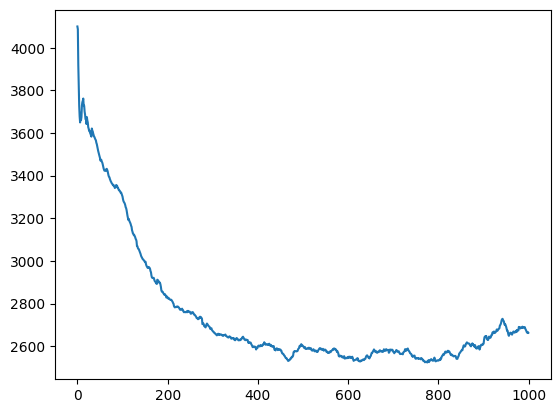

In [26]:
layers1 = [LSTMLayer(hidden_size=256, output_size=62, weight_scale=0.01)]
mod = LSTMModel(layers=layers1,hidden_size = 256,
               vocab_size=62, sequence_length=25,
               loss=SoftmaxCrossEntropyLoss())
optim = AdaGrad(lr=0.01, gradient_clipping=True)
trainer = RNNTrainer('input.txt', mod, batch_size=32,optim=optim)
trainer.train(1000, sample_every=100)

We will go for a deeper LSTM model with smaller sequence length and a lower learning rate and see if it the loss can still go lower and a better text is obtainable

62
Iteration 0 loss: 1636.337752892099
Iteration 100 loss: 1360.3878316928153
Iteration 200 loss: 1302.9797366092782
Iteration 300 loss: 1257.8423661611807
Iteration 400 loss: 1227.2878261371943
Iteration 500 loss: 1228.5191332211946
Iteration 600 loss: 1230.1798270396152
Iteration 700 loss: 1196.6505481088643
Iteration 800 loss: 1182.4566965536503
Iteration 900 loss: 1207.6003209200278
 aome  ee,roiyynse gnu  oruri,m hh e a ,m   hynoy 
h,hen mtn  indh,,o
 shlmrra,r  h,lud, ddthggeshceh,  twyl h ri
,,uo nera h , tnhC gutdehr  dh,e,.uuhse,,reh yr, 
nmdtetfu    :er rome m,,he y
 ,e  ,h


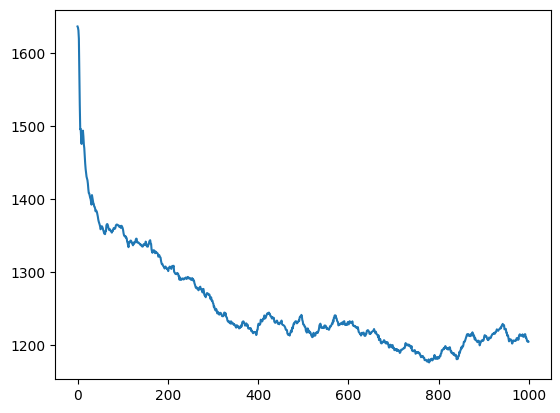

In [27]:
layers1 = [LSTMLayer(hidden_size=256, output_size=128),LSTMLayer(hidden_size=128, output_size=62) ]
mod = LSTMModel(layers=layers1,hidden_size = 256,
               vocab_size=62, sequence_length=10,
               loss=SoftmaxCrossEntropyLoss())
optim = AdaGrad(lr=0.005, gradient_clipping=True)
trainer = RNNTrainer('input.txt', mod, batch_size=32,optim=optim)
trainer.train(1000, sample_every=100)

with the increase in LSTM layers, we again get back the Shakespearean structure , but the words still don't make sense. but we now start seeing some familiar words like rome . with a bigger model and some improvements , we can expect better language modelling.

The model diagrams and some parts of the code are taken from the book Deep learning from scratch by Seth Weidman.